In [1]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
eventname = ''
eventname = 'GW150914' 
# eventname = 'GW151226' 
# eventname = 'LVT151012'
# eventname = 'GW170104'

# want plots?
make_plots = 1
plottype = "png"
#plottype = "pdf"

In [2]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
import readligo as rl

# you might get a matplotlib warning here; you can ignore it.

In [3]:
# Read the event properties from a local json file
fnjson = "BBH_events_v2.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

In [4]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{u'fband': [43.0, 300.0], u'approx': u'lalsim.SEOBNRv2', u'fs': 4096, u'name': u'GW150914', u'utcevent': u'2015-09-14T09:50:45.44', u'fn_H1': u'H-H1_LOSC_4_V2-1126259446-32.hdf5', u'a1': 0.355, u'fn_L1': u'L-L1_LOSC_4_V2-1126259446-32.hdf5', u'm1': 41.743, u'f_min': 10.0, u'fn_template': u'GW150914_4_template.hdf5', u'm2': 29.237, u'tevent': 1126259462.44, u'a2': -0.769}


In [5]:
#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()

In [6]:
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]


# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

('time_H1: len, min, mean, max = ', 131072, 1126259446.0, 1126259461.9998779, 1126259477.9997559)
('strain_H1: len, min, mean, max = ', 131072, -7.0446659431560669e-19, 5.8955225092464373e-23, 7.7062621923974648e-19)
('strain_L1: len, min, mean, max = ', 131072, -1.8697138664279764e-18, -1.0522332249909908e-18, -4.60035111311666e-20)
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


1126259462.44


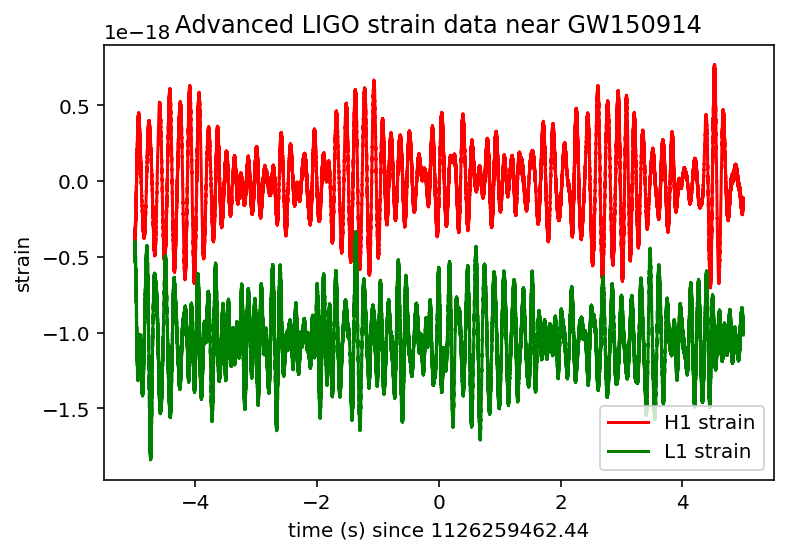

In [7]:
# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_strain.'+plottype)

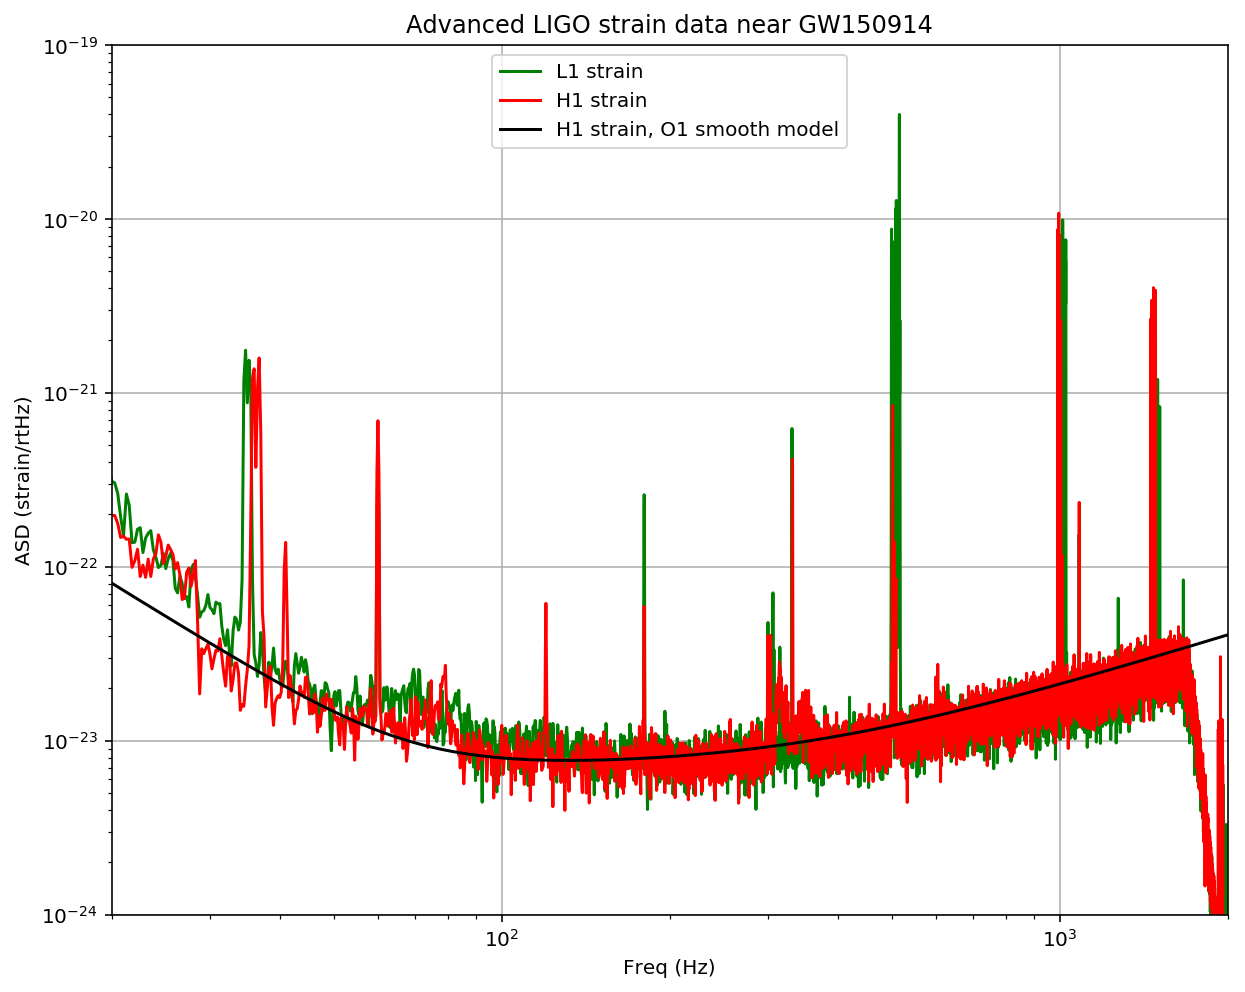

In [8]:
make_psds = 1
if make_psds:
    # number of sample for the fast fourier transform:
    NFFT = 4*fs
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx)

if make_plots:
    # plot the ASDs, with the template overlaid:
    f_min = 20.
    f_max = 2000. 
    plt.figure(figsize=(10,8))
    plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
    plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
    plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_ASDs.'+plottype)

In [9]:
BNS_range = 1
if BNS_range:
    #-- compute the binary neutron star (BNS) detectability range

    #-- choose a detector noise power spectrum:
    f = freqs.copy()
    # get frequency step size
    df = f[2]-f[1]

    #-- constants
    # speed of light:
    clight = 2.99792458e8                # m/s
    # Newton's gravitational constant
    G = 6.67259e-11                      # m^3/kg/s^2 
    # one parsec, popular unit of astronomical distance (around 3.26 light years)
    parsec = 3.08568025e16               # m
    # solar mass
    MSol = 1.989e30                      # kg
    # solar mass in seconds (isn't relativity fun?):
    tSol = MSol*G/np.power(clight,3)     # s
    # Single-detector SNR for detection above noise background: 
    SNRdet = 8.
    # conversion from maximum range (horizon) to average range:
    Favg = 2.2648
    # mass of a typical neutron star, in solar masses:
    mNS = 1.4

    # Masses in solar masses
    m1 = m2 = mNS    
    mtot = m1+m2  # the total mass
    eta = (m1*m2)/mtot**2  # the symmetric mass ratio
    mchirp = mtot*eta**(3./5.)  # the chirp mass (FINDCHIRP, following Eqn 3.1b)

    # distance to a fiducial BNS source:
    dist = 1.0                           # in Mpc
    Dist =  dist * 1.0e6 * parsec /clight # from Mpc to seconds

    # We integrate the signal up to the frequency of the "Innermost stable circular orbit (ISCO)" 
    R_isco = 6.      # Orbital separation at ISCO, in geometric units. 6M for PN ISCO; 2.8M for EOB 
    # frequency at ISCO (end the chirp here; the merger and ringdown follow) 
    f_isco = 1./(np.power(R_isco,1.5)*np.pi*tSol*mtot)
    # minimum frequency (below which, detector noise is too high to register any signal):
    f_min = 20. # Hz
    # select the range of frequencies between f_min and fisco
    fr = np.nonzero(np.logical_and(f > f_min , f < f_isco))
    # get the frequency and spectrum in that range:
    ffr = f[fr]

    # In stationary phase approx, this is htilde(f):  
    # See FINDCHIRP Eqns 3.4, or 8.4-8.5 
    htilde = (2.*tSol/Dist)*np.power(mchirp,5./6.)*np.sqrt(5./96./np.pi)*(np.pi*tSol)
    htilde *= np.power(np.pi*tSol*ffr,-7./6.)
    htilda2 = htilde**2

    # loop over the detectors
    dets = ['H1', 'L1']
    for det in dets:
        if det is 'L1': sspec = Pxx_L1.copy()
        else:           sspec = Pxx_H1.copy()
        sspecfr = sspec[fr]
        # compute "inspiral horizon distance" for optimally oriented binary; FINDCHIRP Eqn D2:
        D_BNS = np.sqrt(4.*np.sum(htilda2/sspecfr)*df)/SNRdet
        # and the "inspiral range", averaged over source direction and orientation:
        R_BNS = D_BNS/Favg
        print(det+' BNS inspiral horizon = {0:.1f} Mpc, BNS inspiral range   = {1:.1f} Mpc'.format(D_BNS,R_BNS))

H1 BNS inspiral horizon = 169.4 Mpc, BNS inspiral range   = 74.8 Mpc
L1 BNS inspiral horizon = 147.1 Mpc, BNS inspiral range   = 64.9 Mpc


In [10]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    print Nt,dt,freqs,len(freqs)
    freqs1 = np.linspace(0,2048.,Nt/2+1)
    print freqs1,len(freqs1)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

whiten_data = 1
if whiten_data:
    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten)

131072 0.000244140625 [  0.00000000e+00   3.12500000e-02   6.25000000e-02 ...,   2.04793750e+03
   2.04796875e+03   2.04800000e+03] 65537
[  0.00000000e+00   3.12500000e-02   6.25000000e-02 ...,   2.04793750e+03
   2.04796875e+03   2.04800000e+03] 65537
131072 0.000244140625 [  0.00000000e+00   3.12500000e-02   6.25000000e-02 ...,   2.04793750e+03
   2.04796875e+03   2.04800000e+03] 65537
[  0.00000000e+00   3.12500000e-02   6.25000000e-02 ...,   2.04793750e+03
   2.04796875e+03   2.04800000e+03] 65537


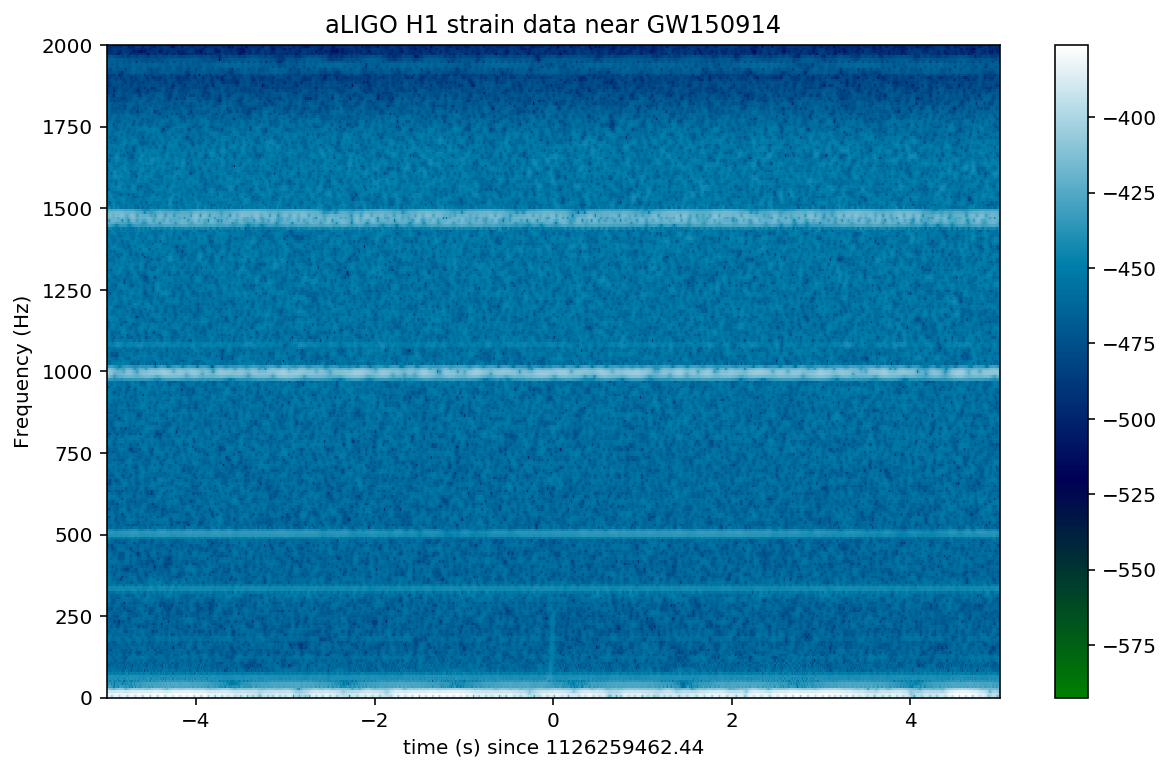

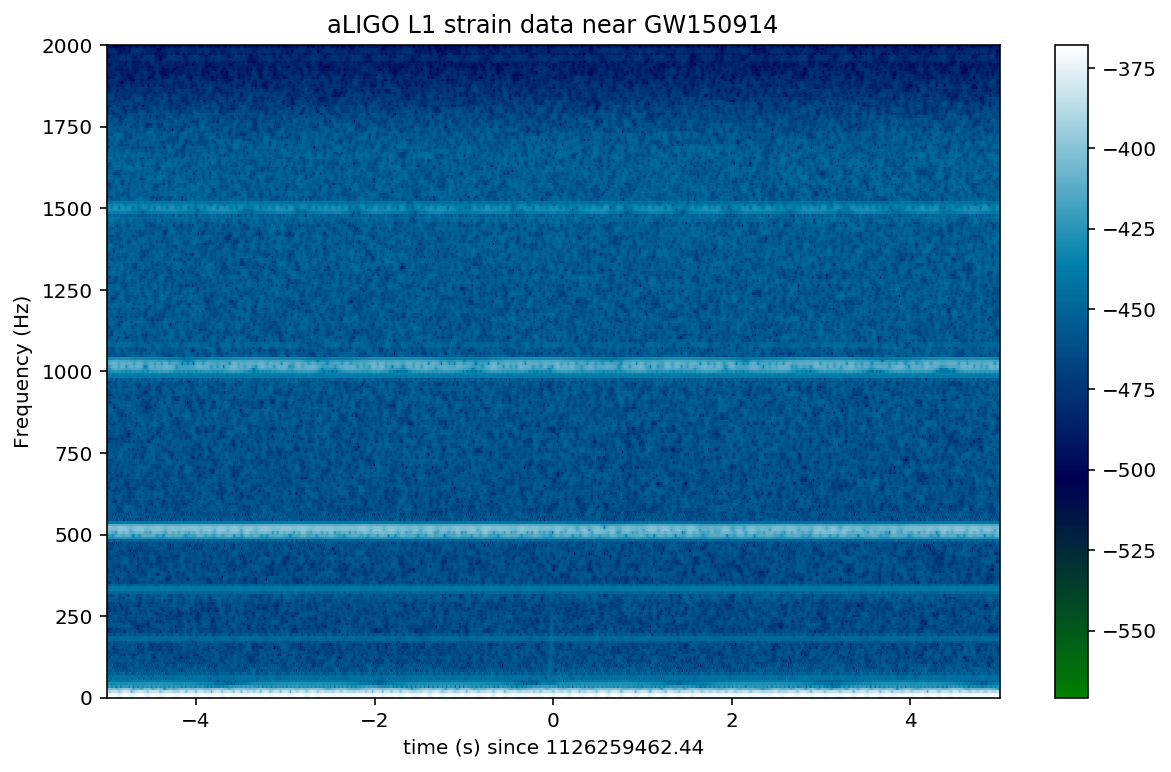

In [11]:
if make_plots:
    # index into the strain time series for this time interval:
    indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

    # pick a shorter FTT time interval, like 1/8 of a second:
    NFFT = int(fs/8)
    # and with a lot of overlap, to resolve short-time features:
    NOVL = int(NFFT*15./16)
    # and choose a window that minimizes "spectral leakage" 
    # (https://en.wikipedia.org/wiki/Spectral_leakage)
    window = np.blackman(NFFT)

    # the right colormap is all-important! See:
    # http://matplotlib.org/examples/color/colormaps_reference.html
    # viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
    #spec_cmap='viridis'
    spec_cmap='ocean'

    # Plot the H1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO H1 strain data near '+eventname)
    plt.savefig(eventname+'_H1_spectrogram.'+plottype)

    # Plot the L1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_L1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO L1 strain data near '+eventname)
    plt.savefig(eventname+'_L1_spectrogram.'+plottype)

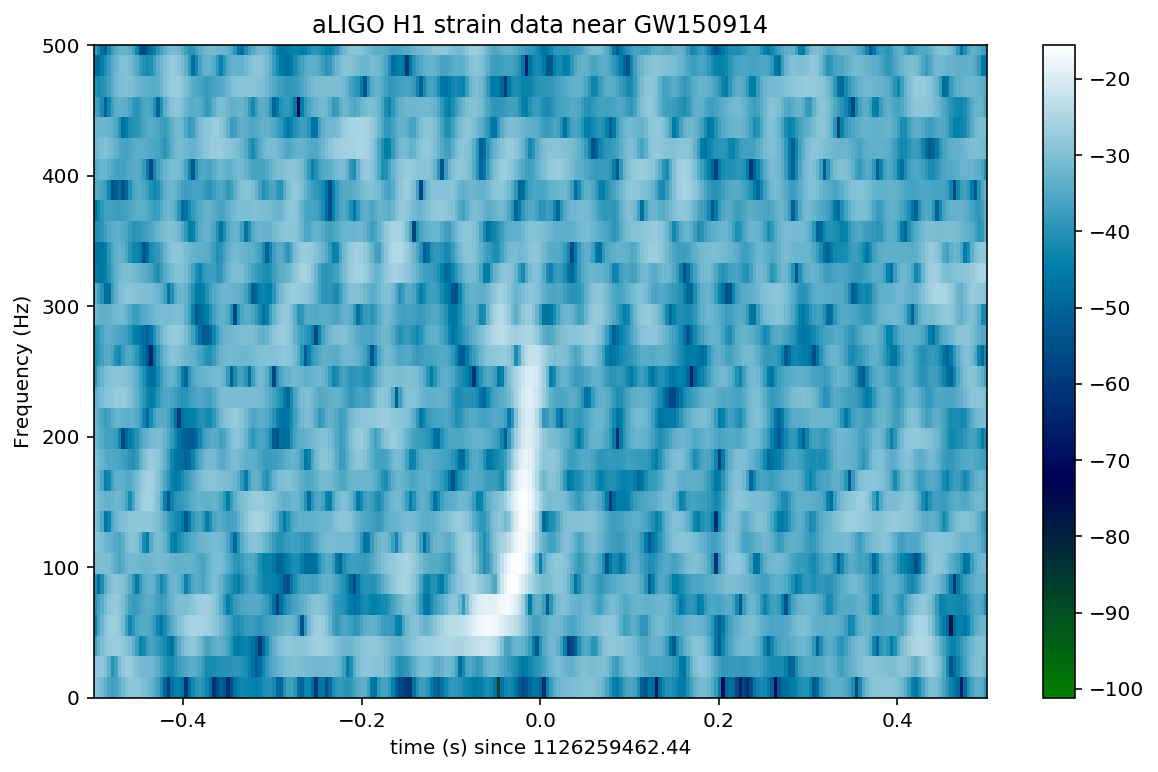

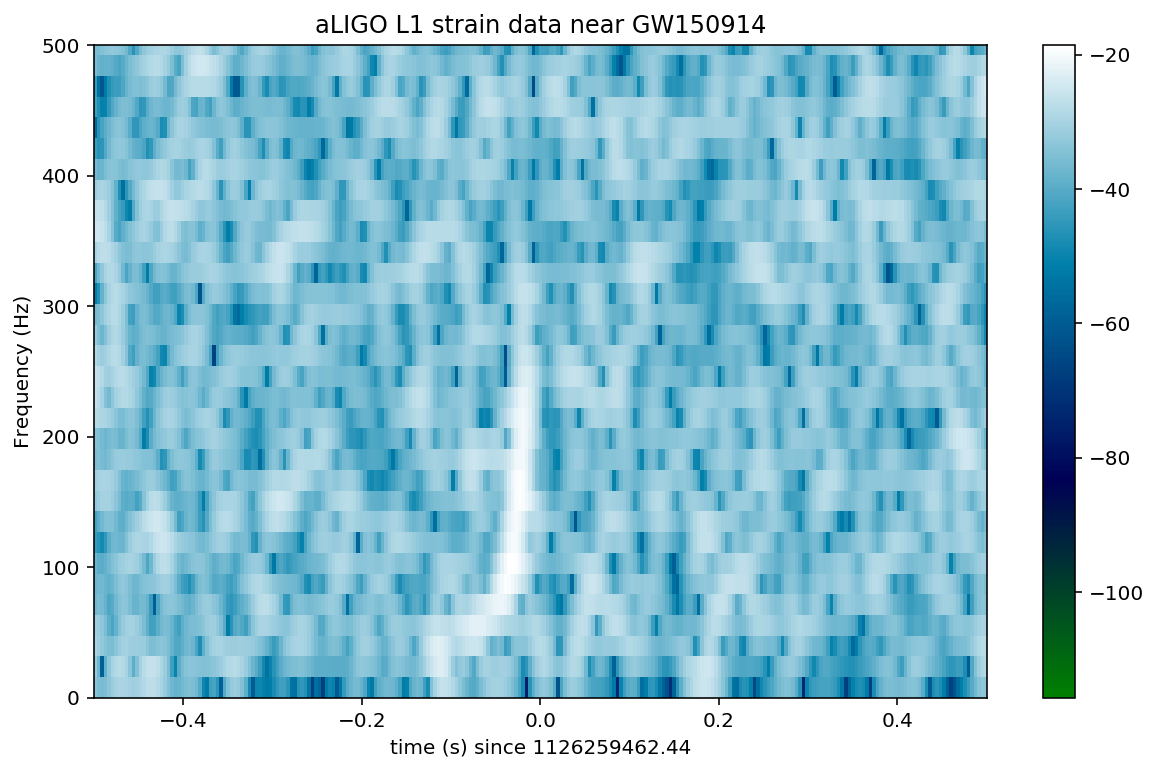

In [12]:
if make_plots:
    #  plot the whitened data, zooming in on the signal region:

    # pick a shorter FTT time interval, like 1/16 of a second:
    NFFT = int(fs/16.0)
    # and with a lot of overlap, to resolve short-time features:
    NOVL = int(NFFT*15/16.0)
    # choose a window that minimizes "spectral leakage" 
    # (https://en.wikipedia.org/wiki/Spectral_leakage)
    window = np.blackman(NFFT)

    # Plot the H1 whitened spectrogram around the signal
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-0.5, 0.5, 0, 500])
    plt.title('aLIGO H1 strain data near '+eventname)
    plt.savefig(eventname+'_H1_spectrogram_whitened.'+plottype)

    # Plot the L1 whitened spectrogram around the signal
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_L1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-0.5, 0.5, 0, 500])
    plt.title('aLIGO L1 strain data near '+eventname)
    plt.savefig(eventname+'_L1_spectrogram_whitened.'+plottype)

In [13]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()

131072 0.000244140625 [  0.00000000e+00   3.12500000e-02   6.25000000e-02 ...,   2.04793750e+03
   2.04796875e+03   2.04800000e+03] 65537
[  0.00000000e+00   3.12500000e-02   6.25000000e-02 ...,   2.04793750e+03
   2.04796875e+03   2.04800000e+03] 65537
131072 0.000244140625 [  0.00000000e+00   3.12500000e-02   6.25000000e-02 ...,   2.04793750e+03
   2.04796875e+03   2.04800000e+03] 65537
[  0.00000000e+00   3.12500000e-02   6.25000000e-02 ...,   2.04793750e+03
   2.04796875e+03   2.04800000e+03] 65537
Properties of waveform template in GW150914_4_template.hdf5
Waveform family = lalsim.SEOBNRv2
Masses = 41.74, 29.24 Msun
Mtot = 70.98 Msun, mfinal = 67.43 Msun 
Spins = 0.35, -0.77
Freq at inband, peak = 43.05, 169.84 Hz
Time at inband, peak = -0.08, -0.02 s
Duration (s) inband-peak = 0.06 s
N_cycles inband-peak = 4
v/c at peak = 0.57
Radius of final BH = 199 km


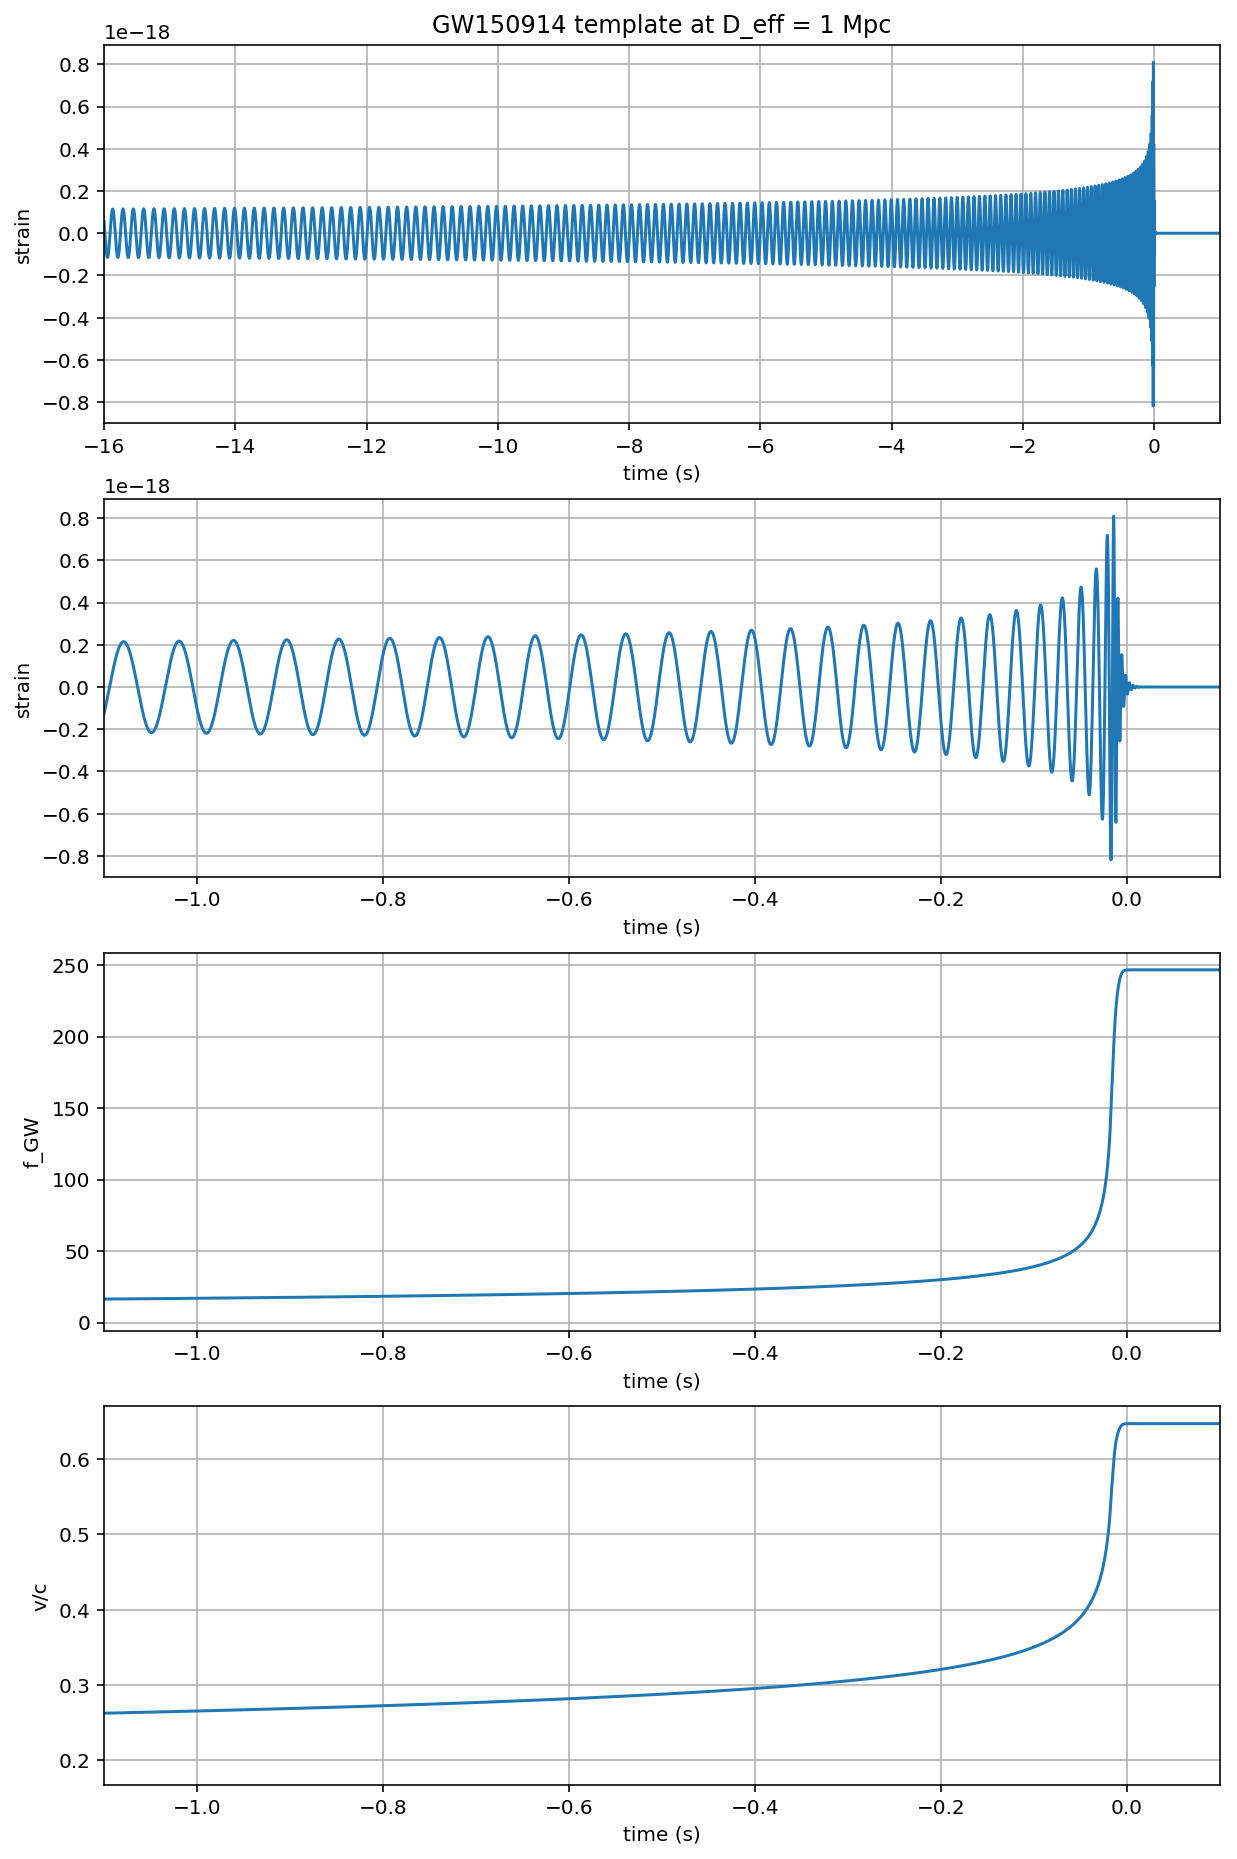

In [14]:
# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

# whiten the templates:
template_p_whiten = whiten(template_p,psd_H1,dt)
template_c_whiten = whiten(template_c,psd_H1,dt)
template_p_whitenbp = filtfilt(bb, ab, template_p_whiten)
template_c_whitenbp = filtfilt(bb, ab, template_c_whiten)

# Compute, print and plot some properties of the template:

# constants:
clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg

# template parameters: masses in units of MSol:
t_mtot = t_m1+t_m2
# final BH mass is typically 95% of the total initial mass:
t_mfin = t_mtot*0.95
# Final BH radius, in km:
R_fin = 2*G*t_mfin*MSol/clight**2/1000.

# complex template:
template = (template_p + template_c*1.j) 
ttime = time-time[0]-template_offset

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.unwrap(np.angle(template))
fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
# iffix = np.where(np.abs(np.gradient(fGW)) > 100.)[0]
iffix = np.where(np.abs(template) < np.abs(template).max()*0.001)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

# compute v/c:
voverc = (G*t_mtot*MSol*np.pi*fGW/clight**3)**(1./3.)

# index where f_GW is in-band:
f_inband = fband[0]
iband = np.where(fGW > f_inband)[0][0]
# index at the peak of the waveform:
ipeak = np.argmax(np.abs(template))

# number of cycles between inband and peak:
Ncycles = (tphase[ipeak]-tphase[iband])/(2.*np.pi)

print('Properties of waveform template in {0}'.format(fn_template))
print("Waveform family = {0}".format(t_approx))
print("Masses = {0:.2f}, {1:.2f} Msun".format(t_m1,t_m2))
print('Mtot = {0:.2f} Msun, mfinal = {1:.2f} Msun '.format(t_mtot,t_mfin))
print("Spins = {0:.2f}, {1:.2f}".format(t_a1,t_a2))
print('Freq at inband, peak = {0:.2f}, {1:.2f} Hz'.format(fGW[iband],fGW[ipeak]))
print('Time at inband, peak = {0:.2f}, {1:.2f} s'.format(ttime[iband],ttime[ipeak]))
print('Duration (s) inband-peak = {0:.2f} s'.format(ttime[ipeak]-ttime[iband]))
print('N_cycles inband-peak = {0:.0f}'.format(Ncycles))
print('v/c at peak = {0:.2f}'.format(voverc[ipeak]))
print('Radius of final BH = {0:.0f} km'.format(R_fin))

if make_plots:
    plt.figure(figsize=(10,16))
    plt.subplot(4,1,1)
    plt.plot(ttime,template_p)
    plt.xlim([-template_offset,1.])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    plt.title(eventname+' template at D_eff = 1 Mpc')
    
    plt.subplot(4,1,2)
    plt.plot(ttime,template_p)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    #plt.title(eventname+' template at D_eff = 1 Mpc')
    
    plt.subplot(4,1,3)
    plt.plot(ttime,fGW)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('f_GW')
    #plt.title(eventname+' template f_GW')
    
    plt.subplot(4,1,4)
    plt.plot(ttime,voverc)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('v/c')
    #plt.title(eventname+' template v/c')
    plt.savefig(eventname+'_template.'+plottype)

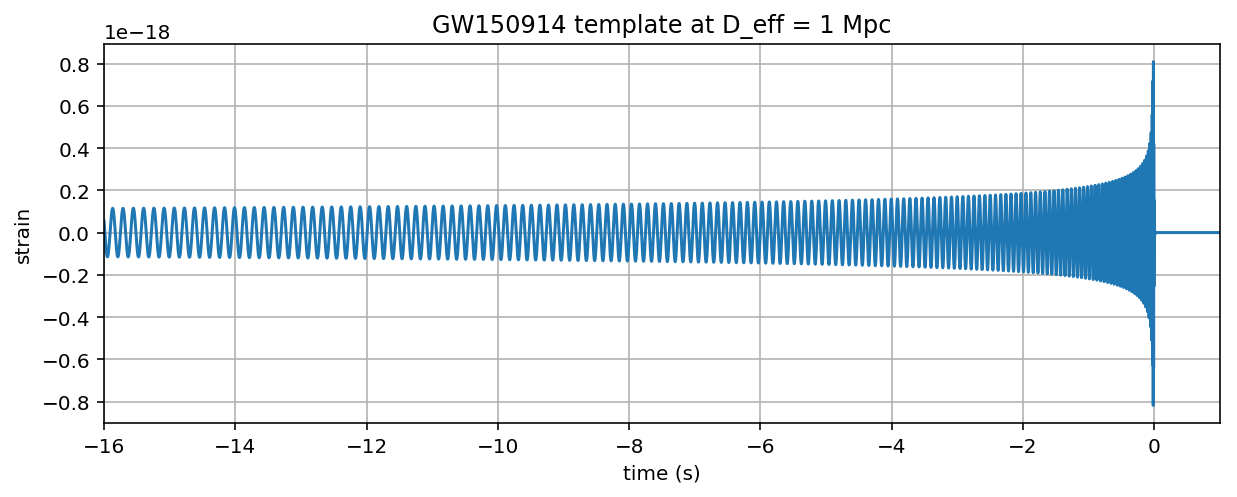

In [15]:
if make_plots:
    plt.figure(figsize=(10,16))
    plt.subplot(4,1,1)
    plt.plot(ttime,template_p)
    plt.xlim([-template_offset,1.])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    plt.title(eventname+' template at D_eff = 1 Mpc')

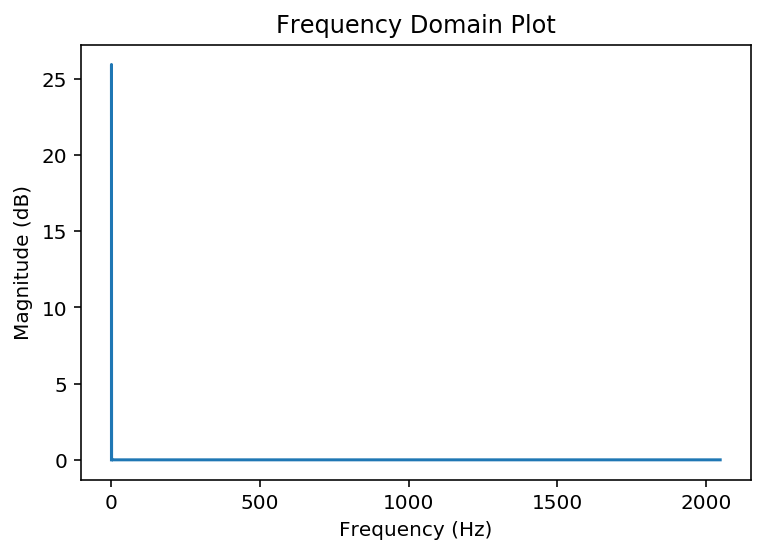

In [16]:
#Take the fft and normalize
template_p = np.fft.fft(ttime)/len(ttime)
import math as m

#Use only the first half of the data
template_p = template_p[0:len(ttime)/2]

#Get the magnitude in decibels
mag = np.abs(template_p)**2

#Set the x-axis
w = np.linspace(0,m.ceil(fs/2),len(template_p))

#Plot it!
plt.plot(w, mag)
plt.title('Frequency Domain Plot')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.show()

In [17]:
# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# define the complex template, common to both detectors:
template = (template_p + template_c*1.j) 
# We will record the time where the data match the END of the template.
etime = time+template_offset
# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

# loop over the detectors
dets = ['H1', 'L1']
for det in dets:

    if det is 'L1': data = strain_L1.copy()
    else:           data = strain_H1.copy()

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]

    # Calculate the "effective distance" (see FINDCHIRP paper for definition)
    # d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)
    #print offset

    # apply time offset, phase, and d_eff to whitened template, for plotting
    template_whitened = (template_p_whitenbp + template_c_whitenbp*1.j) 
    template_phaseshifted = np.real(template_whitened*np.exp(1j*phase))
    template_match = np.roll(template_phaseshifted,offset) / d_eff

    print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, D_eff = {3:.2f}, horizon = {4:0.1f} Mpc' 
          .format(det,timemax,SNRmax,d_eff,horizon))

    if make_plots:

        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp

        # -- Plot the result
        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
        #plt.ylim([0,25.])
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.title(det+' matched filter SNR around event')

        # zoom in
        plt.subplot(2,1,2)
        plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlim([-0.15,0.05])
        #plt.xlim([-0.3,+0.3])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.savefig(eventname+"_"+det+"_SNR."+plottype)

        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
        plt.plot(time-tevent,template_match,'k',label='Template(t)')
        plt.ylim([-3,3])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left')
        plt.title(det+' whitened data around event')

        plt.subplot(2,1,2)
        plt.plot(time-tevent,strain_whitenbp-template_match,pcolor,label=det+' resid')
        plt.ylim([-3,3])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left')
        plt.title(det+' Residual whitened data after subtracting template around event')
        plt.savefig(eventname+"_"+det+"_matchtime."+plottype)
                 
        # -- Display PSD and template
        # must multiply by sqrt(f) to plot template fft on top of ASD:
        plt.figure(figsize=(10,6))
        template_f = np.absolute(template_fft)*np.sqrt(np.abs(datafreq)) / d_eff
        plt.loglog(datafreq, template_f, 'k', label='template(f)*sqrt(f)')
        plt.loglog(freqs, np.sqrt(data_psd),pcolor, label=det+' ASD')
        plt.xlim(20, fs/2)
        plt.ylim(1e-24, 1e-20)
        plt.grid()
        plt.xlabel('frequency (Hz)')
        plt.ylabel('strain noise ASD (strain/rtHz), template h(f)*rt(f)')
        plt.legend(loc='upper left')
        plt.title(det+' ASD and template around event')
        plt.savefig(eventname+"_"+det+"_matchfreq."+plottype)

ValueError: operands could not be broadcast together with shapes (65536,) (131072,) 

In [ ]:
# make wav (sound) files from the whitened data, +-2s around the event.

from scipy.io import wavfile

# function to keep the data within integer limits, and write to wavfile:
def write_wavfile(filename,fs,data):
    d = np.int16(data/np.max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(filename,int(fs), d)

deltat_sound = 2.                     # seconds around the event

# index into the strain time series for this time interval:
indxd = np.where((time >= tevent-deltat_sound) & (time < tevent+deltat_sound))

# write the files:
write_wavfile(eventname+"_H1_whitenbp.wav",int(fs), strain_H1_whitenbp[indxd])
write_wavfile(eventname+"_L1_whitenbp.wav",int(fs), strain_L1_whitenbp[indxd])

# re-whiten the template using the smoothed PSD; it sounds better!
template_p_smooth = whiten(template_p,psd_smooth,dt)

# and the template, sooming in on [-3,+1] seconds around the merger:
indxt = np.where((time >= (time[0]+template_offset-deltat_sound)) & (time < (time[0]+template_offset+deltat_sound)))
write_wavfile(eventname+"_template_whiten.wav",int(fs), template_p_smooth[indxt])
#plt.plot(template_p_smooth[indxt])

In [ ]:
# function that shifts frequency of a band-passed signal
def reqshift(data,fshift=100,sample_rate=4096):
    """Frequency shift the signal by constant
    """
    x = np.fft.rfft(data)
    T = len(data)/float(sample_rate)
    df = 1.0/T
    nbins = int(fshift/df)
    # print T,df,nbins,x.real.shape
    y = np.roll(x.real,nbins) + 1j*np.roll(x.imag,nbins)
    y[0:nbins]=0.
    z = np.fft.irfft(y)
    return z

# parameters for frequency shift
fs = 4096
fshift = 400.
speedup = 1.
fss = int(float(fs)*float(speedup))

# shift frequency of the data
strain_H1_shifted = reqshift(strain_H1_whitenbp,fshift=fshift,sample_rate=fs)
strain_L1_shifted = reqshift(strain_L1_whitenbp,fshift=fshift,sample_rate=fs)

# write the files:
write_wavfile(eventname+"_H1_shifted.wav",int(fs), strain_H1_shifted[indxd])
write_wavfile(eventname+"_L1_shifted.wav",int(fs), strain_L1_shifted[indxd])

# and the template:
template_p_shifted = reqshift(template_p_smooth,fshift=fshift,sample_rate=fs)
write_wavfile(eventname+"_template_shifted.wav",int(fs), template_p_shifted[indxt])

In [ ]:
fna = eventname+"_template_shifted.wav"
print(fna)
from IPython.display import Audio
Audio(fna)

In [ ]:
data_segments = 1
if data_segments:
    # read in the data at 4096 Hz:
    # fn = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
    strain, time, chan_dict = rl.loaddata(fn_L1, 'H1')

    print("Contents of all the key, value pairs in chan_dict")
    for keys,values in chan_dict.items():
        print(keys)
        print(values)

    print('Total number of non-NaNs in these data = ',np.sum(~np.isnan(strain)))
    print('GPS start, GPS stop and length of  all data in this file = ',time[0], time[-1],len(strain))

    # select the level of data quality; default is "DATA" but "CBC_CAT3" is a conservative choice:
    DQflag = 'CBC_CAT3'
    # readligo.py method for computing segments (start and stop times with continuous valid data):
    segment_list = rl.dq_channel_to_seglist(chan_dict[DQflag])
    print('Number of segments with DQflag',DQflag,' = ',len(segment_list))

    # loop over seconds and print out start, stop and length:
    iseg = 0
    for segment in segment_list:
        time_seg = time[segment]
        seg_strain = strain[segment]
        print('GPS start, GPS stop and length of segment',iseg, \
            'in this file = ',time_seg[0], time_seg[-1], len(seg_strain))
        iseg = iseg+1
        # here is where you would insert code to analyze the data in this segment.

    # now look at segments with no CBC hardware injections:
    DQflag = 'NO_CBC_HW_INJ'
    segment_list = rl.dq_channel_to_seglist(chan_dict['NO_CBC_HW_INJ'])
    print('Number of segments with DQflag',DQflag,' = ',len(segment_list))
    iseg = 0
    for segment in segment_list:
        time_seg = time[segment]
        seg_strain = strain[segment]
        print('GPS start, GPS stop and length of segment',iseg, \
            'in this file = ',time_seg[0], time_seg[-1], len(seg_strain))
        iseg = iseg+1